# Object-Oriented Programming, part 2

In this notebook we'll talk more about the type system-related aspects of object-oriented programming in Scala.

First, something you've surely seen before:

## Inheritance - the essentials

Scala has single class inheritance, much like most other languages.

In [51]:
class Animal {
    def eat: Unit = "nomnomnom"
}

class Cat extends Animal
class Dog extends Animal 

defined class Animal
defined class Cat
defined class Dog

### Access modifiers

"Extending" a class means inheriting all members (fields + methods) from that class, which are not private. So in the case above, `Dog` and `Cat` will both have the method `eat`.

Marking a member as private requires the `private` access modifier. So this example

In [51]:
class Animal {
    private def eat: Unit = "nomnomnom"
}

class Cat extends Animal
class Dog extends Animal 

val cat = new Cat
cat.eat

cmd51.sc:9: value eat is not a member of Helper.this.Cat
val res51_4 = cat.eat
                  ^

: 

will not compile because we're calling the method `eat` which is private only for the class `Animal`, so the `Cat` class will not inherit it, so we can't call it.

Now that we're on the subject, the access modifiers that you can add to members are:

* `private` - we've already discussed, restricts visibility and inheritance to the containing class only
* `protected` - allows inheritance of this member, but can only be used or called inside the class and descendants
* no modifier - means "public", which allows any piece of code to access this member

### Constructors

If a parent class has a custom constructor (with parameters, that is), you need to pass constructor arguments when you extend it:

In [51]:
class Person(name: String, age: Int)
class Adult(name: String, age: Int, ssNumber: Int) extends Person
// won't compile

cmd51.sc:2: not enough arguments for constructor Person: (name: String, age: Int)Helper.this.Person.
Unspecified value parameters name, age.
class Adult(name: String, age: Int, ssNumber: Int) extends Person
                                                           ^

: 

This happens because whenever you instantiate a derived class, _the JVM will need to call a constructor from the parent class first_ (JVM rule). The Scala compiler forces you to guarantee that there is a correct super-constructor to call when using a derived class, so you must pass in the correct arguments, otherwise the compiler will look (and fail) to find a constructor that looks like the one you provided. In the example above, the constructor `Person` with no arguments does not exist.

In [52]:
class Person(name: String, age: Int)
class Adult(name: String, age: Int, ssNumber: Int) extends Person(name, age)
// correct, you've passed in constructor arguments for the superclass

defined class Person
defined class Adult

### Overriding Members

When inheriting members (fields or methods) from a parent class, you can supply a different definition for them in the derived class (_overriding_). In Scala you need to use the `override` keyword to do it:

In [53]:
class Animal {
    val creatureType: String = "wild"
    def eat: Unit = println("nom nom...")
}

class Dog extends Animal {
    override val creatureType: String = "domestic"
    override def eat: Unit = println("crunch, crunch...")
}

defined class Animal
defined class Dog

Fields have the special property that they can be overridden as a class parameter as well:

In [54]:
class Dog(override val creatureType: String) extends Animal {
    override def eat: Unit = println("crunch, crunch...")
}

defined class Dog

The main idea of overriding is that **all instances of derived classes will use the overridden methods whenever possible**. In the case above, all instances of `Dog` will print "crunch, crunch..." when we call the method `eat`. What's interesting, though, is that we can do a type substitution:

In [55]:
val unknownAnimal: Animal = new Dog("K9")

unknownAnimal: Animal = $sess.cmd53Wrapper$Helper$Dog@48a5fc80

So as you see, we can declare something to be an `Animal` and supply a `Dog` instead. This is called (in a very broad sense) **polymorphism**. The most interesting thing about it is that when I say

In [56]:
unknownAnimal.eat

crunch, crunch...


it uses the _derived_ (overridden) implementation of `eat` because `unknownAnimal`, although declared an `Animal`, is actually an instance of `Dog` so will use `Dog`'s methods instead.

Keep in mind: **a method call will always go to the overridden version whenever possible**.

Also be careful to **make the difference between**
* **_overriding_ = re-implementing a method in a derived class**
* **_overloading_ = creating a _new_ method with a different signature in the same class**

### `super`

If you ever need to reference a method or value from a parent class, use `super`:

In [57]:
class Dog(override val creatureType: String) extends Animal {
    override def eat: Unit = {
        // call parent method
        super.eat
        println("crunch, crunch...")
    }
}

new Dog("K9").eat

nom nom...
crunch, crunch...


defined class Dog

### Preventing Overrides

Method 1: use `final` for fields or methods that you want to prevent from being overridden:<br/>

In [57]:
class Animal {
    final def eat: Unit = println("nom nom")
}

class Dog extends Animal {
    override def eat: Unit = println("crunch")
}

cmd57.sc:6: overriding method eat in class Animal of type => Unit;
 method eat cannot override final member
    override def eat: Unit = println("crunch")
                 ^

: 

Method 2: use `final` on the actual class to prevent the entire class from being extended in the first place:

In [57]:
final class Animal {
    def eat: Unit = println("nom nom")
}

class Dog extends Animal

cmd57.sc:5: illegal inheritance from final class Animal
class Dog extends Animal
                  ^

: 

Method 3: _seal_ the parent class with all its children in the same source file - use the `sealed` keyword to do it. All other attempted extensions to that parent class will be forbidden (run both cells below to prove):

In [58]:
// source file #1
sealed class Animal
class Dog extends Animal

defined class Animal
defined class Dog

In [58]:
// source file #2
class Cat extends Animal

cmd58.sc:1: illegal inheritance from sealed class Animal
class Cat extends Animal
                  ^

: 

### Abstract classes

There are situations when you need to leave some fields "blank" or methods unimplemented - these are called abstract members. Classes which contain unimplmented methods are called **abstract classes**.

In [59]:
abstract class Animal {
    val creatureType: String
    def eat: Unit
}

defined class Animal

The blank fields or unimplemented methods are called _abstract_ (of course). One thing to note: **abstract classes cannot be instantiated** - it should make sense, because an instance of a class has to have all fields and methods defined. Otherwise, how would the runtime know what to execute when you call `eat()` on an `Animal`?!

In [59]:
class Dog extends Animal

cmd59.sc:1: class Dog needs to be abstract, since:
it has 2 unimplemented members.
/** As seen from class Dog, the missing signatures are as follows.
 *  For convenience, these are usable as stub implementations.
 */
  val creatureType: String = ???
  def eat: Unit = ???

class Dog extends Animal
      ^

: 

The above code fails to compile. The compiler is very helpful here and tells you that you should either
* implement the undefined members
* OR make `Dog` abstract as well

So the way to correctly define `Dog` is to simply provide an implementation for the abstract fields:

In [60]:
class Dog extends Animal {
    override val creatureType: String = "Canine"
    override def eat: Unit = println("crunch, crunch...")
}

defined class Dog

Technically, providing an implementation qualifies as _overriding_, but the `override` keyword is not mandatory for abstract members - the compiler is smart enough to figure out there's no prior implementation to replace.

### Traits

Traits are the ultimate abstract types.

In [61]:
trait Closeable {
    val closingFlags: Int
    def close: Unit
}

defined trait Closeable

Much like an abstract class, a trait has abstract members and cannot be instantiated on its own. What's special is that a trait can be inherited _alongsied_ a class:

In [62]:
class CarnivorePlant extends Animal with Closeable {
                        //     ^     ^ keyword to bring in a trait as well
                        //     ^ don't really know if it's an animal or not; you get the point.
    
    val creatureType: String = "Killer"
    def eat: Unit = println("crack!")
    val closingFlags = 0
    def close: Unit = { /* clasp */ }
}

defined class CarnivorePlant

or inherited directly:

In [63]:
class Stream(val closingFlags: Int) extends Closeable {
    def close: Unit = { /* flush IO buffers etc */ }
}

defined class Stream

On the other hand (sigh...), traits can also have non-abstract members (fields or methods) as "default" implementations. Which begs the question: how are traits different from abstract classes?

For one, **traits can't have constructor parameters**. This is a hard, practical difference.<br/>
Second, and this is a more subtle matter of choice: we choose a trait (vs an abstract class) if it describes a type of _behavior_, and names are usually descriptive: Closeable, Runnable, etc. By contrast, we choose an abstract class if it describes a type of "thing": Animal, Organization, Person, etc. which can later be derived.

### The type hierarchy in a nutshell

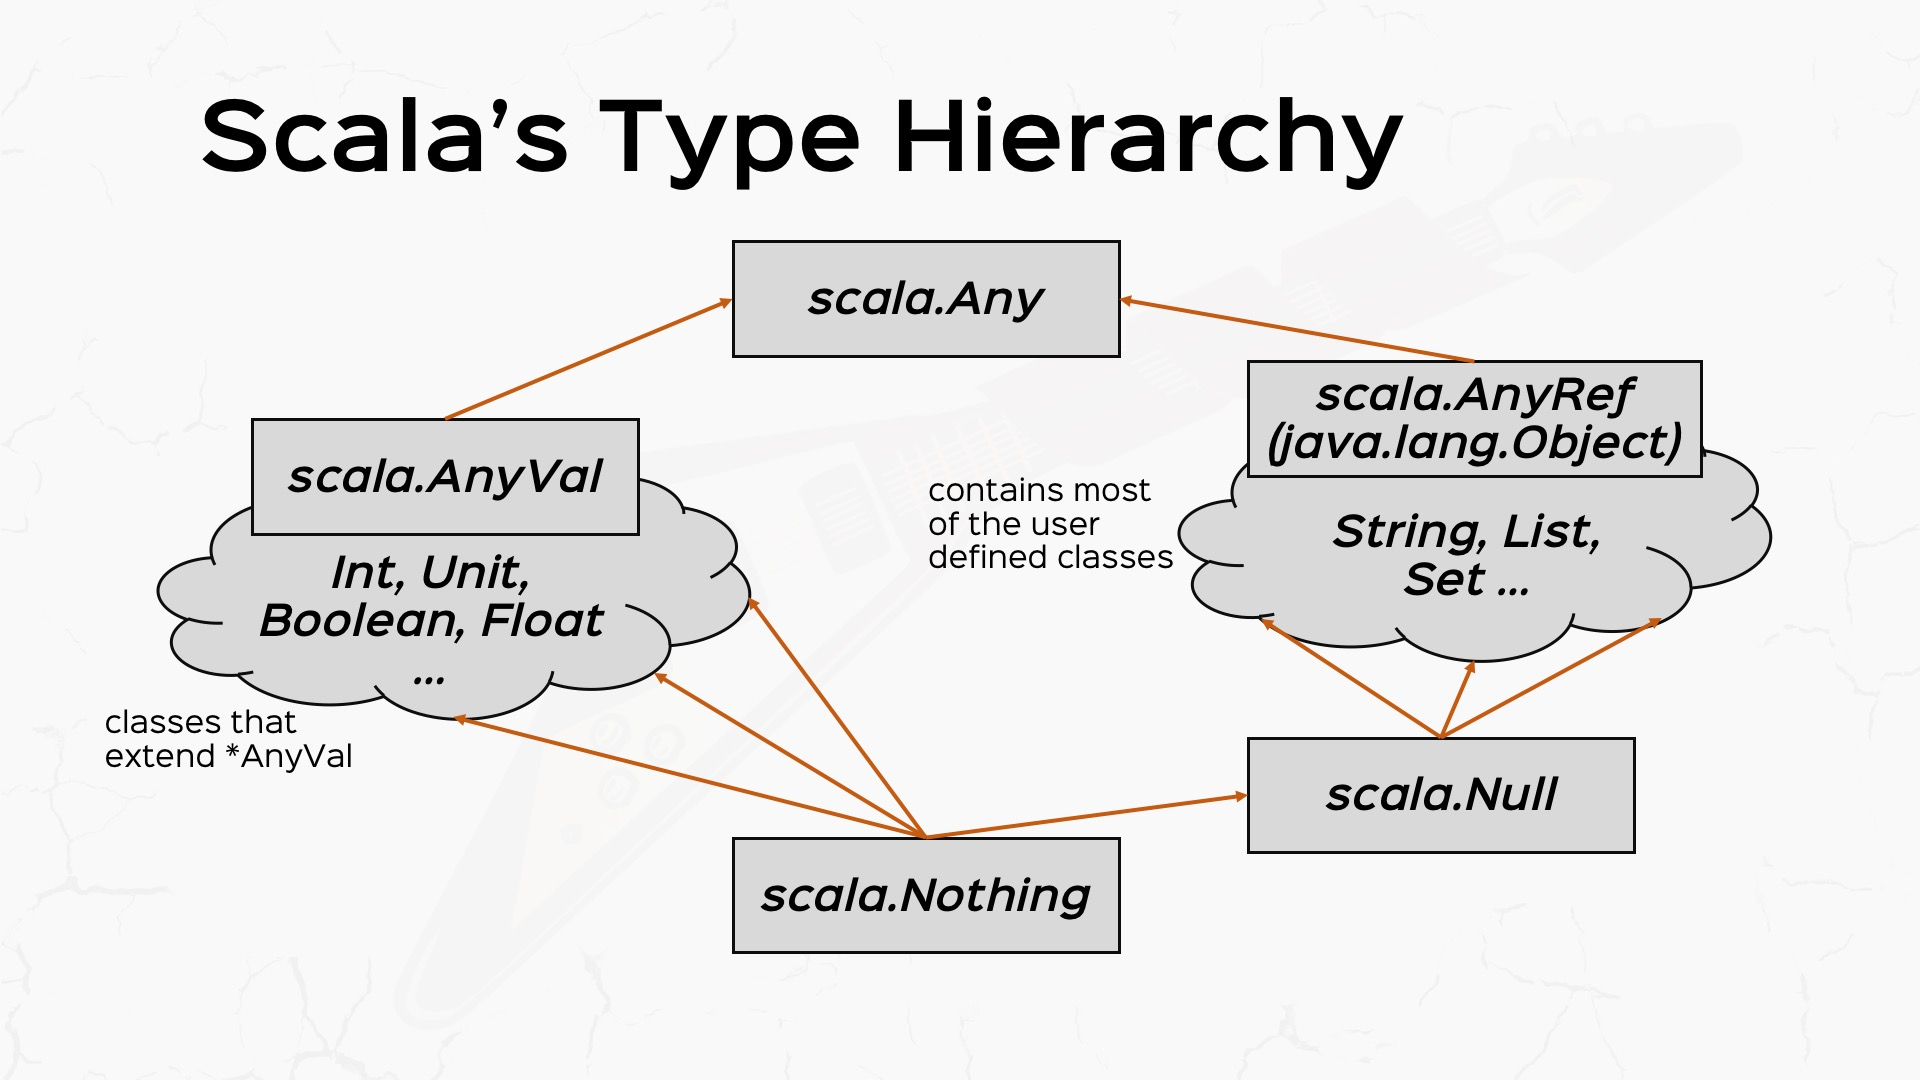

In short:

* `Any` is the mother of all types.
* `AnyVal` is "value" types like `Int`. You'll likely never extend an `AnyVal` for any practical reason. Most Scala * * `AnyVal`s are for JVM mapping only (mapping to primitive `int`s, `boolean`s, etc).
* `AnyRef` is the "normal" mother of all types (mapped to Java's `Object` type). All classes you'll use will derive from `AnyRef` unless you explicitly say they `extend` some other class.
* `Null` is a singleton type and has the `null` reference. Any reference type can be replaced with `Null`, because any reference can have the value `null`.
* `Nothing` is a special type with no instances. It is the "child" of every other type in the sense that every type can be replaced with `Nothing`. `Nothing` means no instance of anything, not even `null`, not even `Unit`. It's the type of nothingness, if you will. **The expressions `???` and `throw` (we'll talk more shortly) return `Nothing`.**

## Intro to Generics

You can specify type parameters to reuse the same code on potentially unrelated types. Collections are a powerful use case:

In [64]:
trait List[T] {
    def add(element: T): List[T]
}

defined trait List

That `[T]` is a type parameter, which means that inside the class you can refer to the same type as `T` in a general way. Later when you use the class e.g. `val l = new List[String]`, that `T` will be replaced with a concrete type (`String` in this case) and you can use the methods with that type, e.g. `list.add("learning")`. You can specify multiple type parameters inside `[]`:

In [66]:
trait Map[K, V]

defined trait Map

With generics, the compiler does a lot of work for you to check you're using the right types in the right places. For example, it will complain when you attempt to add an `Int` to a `List[String]`.

Generics part 2: methods. If declaring a generic class or trait is too much and you want to go granular, you can add type parameters to methods as well:

In [68]:
def emptyList[A]: List[A] = {
    // now you can use the type A throughout the function implementation
    ???
}

defined function emptyList

### The Variance Problem

Now in the context of inheritance, a natural question arises on generics: who should extend what?

Best example with lists. Say we have types `A` and `B extends A`. Should `List[B]` extend `List[A]`? We have 3 options:
1. yes (covariance)
2. no (invariance)
3. hell no (contravariance)

In [69]:
trait List[+A] // covariant List, see the + sign
trait Container[A] // invariant container
trait Action[-A] // contravariant container, see the - sign

defined trait List
defined trait Container
defined trait Action

The variance problem arises when we want to do type substitutions ("polymorphism"). As an example, given an imaginary hierarchy of `Animal`s, `Cat`s and `Dog`s, here are some natural questions:

**Interesting question #1**: (covariance) `val list: List[Animal] = new List[Cat]`. Is this ok? What if I add a `Dog` in `list`? `Dog` is an `Animal` so I should, in theory, be able to add it to `list` (being declared as `List[Animal]`) but I'm adding a `Dog` to a list of `Cat`s...

**Interesting question #2**: (contravariance) If I'm an `Animal` trainer (= I can train any animal), I should be able to train both a `Cat` and a `Dog`, right? So in theory I could say `val trainer: Trainer[Cat] = new Trainer[Animal]`?

Food for thought. We won't get into too many details here, we'll talk more when we start diving into Scala's type system, but you should start thinking about what makes sense and what doesn't.

### Bounded types

You can restrict which types your generic classes/traits/methods allow:

In [69]:
class Animal
class Dog extends Animal

class Cage[A <: Animal](animal: A)

new Cage(new Dog)
new Cage("hello generics")

cmd69.sc:7: inferred type arguments [String] do not conform to class Cage's type parameter bounds [A <: Helper.this.Animal]
val res69_4 = new Cage("hello generics")
              ^cmd69.sc:7: type mismatch;
 found   : String("hello generics")
 required: A
val res69_4 = new Cage("hello generics")
                       ^

: 

As you see, compilation fails for the last statement because `String` doesn't extend `Animal`. The syntax is: 
- `X <: Y` for "my generic type X has to be a _subclass_ of Y"
- `X >: Y` for "my generic type X has to be a _superclass_ of Y"

Bounded types solve a variance problem. Example. You're really determined to make `List[A]` a covariant list. Now because of the interesting question #1 above, you can't simply add things to a covariant list because you might pollute it with the wrong types. 

In [77]:
trait List[+A] {
    def add(elem: A): List[A]
}

cmd77.sc:2: covariant type A occurs in contravariant position in type A of value elem
    def add(elem: A): List[A]
            ^

: 

The above is one of the cryptic errors which you won't understand until you've gone through how Scala's type system works. We won't discuss the error itself for now, but we'll talk about a solution.

The way you could do this is by "widening" the type of the list. That is, if you have a list of `Cat`s and you want to add a `Dog` to it, the resulting list would become a list of, say, `Mammal` to keep logical integrity (= all elements in the list must have the same type).

In [78]:
class Animal
class Mammal extends Animal
class Dog extends Mammal
class Cat extends Mammal

class List[+A] {
    def add[B >: A](elem: B): List[B] = new List[B] // actual implementation not important
}

val list: List[Cat] = new List[Cat]

defined class Animal
defined class Mammal
defined class Dog
defined class Cat
defined class List
list: wrapper.wrapper.List[wrapper.wrapper.Cat] = $sess.cmd77Wrapper$Helper$List@c174fee

This is the way to solve the addition problem: you force the parameter to be of a supertype of your current type, in order to "widen" it if you add an instance of any other type. To use it, just say

In [79]:
val dog: Mammal = new Dog 
val newList = list.add(dog)

dog: Mammal = $sess.cmd77Wrapper$Helper$Dog@798b46be
newList: List[Mammal] = $sess.cmd77Wrapper$Helper$List@5c203c23

See how the compiler inferred `newList` to be a `List[Mammal]`? 

This also works if you don't explicitly say `dog` is a `Mammal`, the compiler will automatically cast it to the lowest common ancestor of `Cat` and `Dog`:

In [80]:
val dog: Dog = new Dog // it's important that Dog be declared as Mammal
val newList = list.add(dog)

dog: Dog = $sess.cmd77Wrapper$Helper$Dog@20ab529f
newList: List[Mammal] = $sess.cmd77Wrapper$Helper$List@6b6d4e79

This is a bit of type system magic in here, but we hope you got a taste of it. There's a lot more going on and we're going to explore the Scala type system in detail, but a bit later.